## 항공사 만족도: 항공사는 어디에 투자해야 좋은 평가를 받을 수 있을까?

### 사용 데이터: 항공사 승객 만족도 데이터 (103,904명)

- 고객 정보: 충성도(Loyal/Disloyal), 클래스(Economy/Eco-plus/Business), 비행 거리(Short/Medium/Long)
- 서비스 평가: 14개 항목 (좌석, Wi-Fi, Entertainment, 탑승, 청결 등) 1-5점 척도
- 운영 데이터: 출발/도착 지연 시간(분)
- 만족도: 만족(satisfied) / 중립 또는 불만족(neutral or dissatisfied)

### 목적: 위 데이터를 사용해서 항공사 입장에서 투자 우선순위를 활용하여 고객 만족도를 쉽게 높일 수 있는 전략을 분석


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows의 경우)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [3]:
df = pd.read_csv('../data/train_raw.csv')
df.head()

# 만족도 label 인코딩
df['label'] = df['satisfaction'].map({
    'neutral or dissatisfied': 0,
    'satisfied': 1
})

# 모든 서비스 변수
service_cols = [
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

# service_cols에서 0은 평가하지 않음 -> NaN으로 변경
df[service_cols] = df[service_cols].replace(0, np.nan)

In [4]:
print(df.columns)

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction', 'label'],
      dtype='object')


In [5]:
# 전체 데이터에서 만족도 비율
satisfaction = df['satisfaction'].value_counts(normalize=True).reset_index()
satisfaction.columns = ['Satisfaction', 'Ratio']
satisfaction

,Satisfaction,Ratio
0,neutral or dissatisfied,0.566667
1,satisfied,0.433333


### 전체 만족도는 43.4%, 절반이 넘는 승객이 불만족. 왜? 자주 이용하는 충성 고객이라면 만족할까?

### 가설 1: 더 자주 이용하는 충성 고객(Loyal Customer)이 더 높은 만족도를 가질 것이다.

In [6]:
# Loyal/Disloyal의 만족도 비율
loyal = df[df['Customer Type'] == 'Loyal Customer'].copy()
disloyal = df[df['Customer Type'] == 'disloyal Customer'].copy()

loyal_rate = loyal['label'].mean()
disloyal_rate = disloyal['label'].mean()

print(f"Loyal 고객 만족률 : {loyal_rate:.4f}")
print(f"Disloyal 고객 만족률 : {disloyal_rate:.4f}")

Loyal 고객 만족률 : 0.4773
Disloyal 고객 만족률 : 0.2367


**결과:** 충성 고객 만족도 47.7% vs 비충성 23.7% (2배 높지만 절반도 안 됨)

--> 충성 고객과 비충성 고객은 기대치가 달라서 그런가?<br/>
--> 충성 고객과 비충성 고객 그룹이 각각 서비스를 어떻게 평가했는지 비교 필요

[Loyal Customer 상관계수]
Online boarding           0.541785
Inflight entertainment    0.461086
Seat comfort              0.398033
Name: label, dtype: float64

[Disloyal Customer 상관계수]
Inflight wifi service     0.669604
Ease of Online booking    0.630059
Online boarding           0.593407
Name: label, dtype: float64


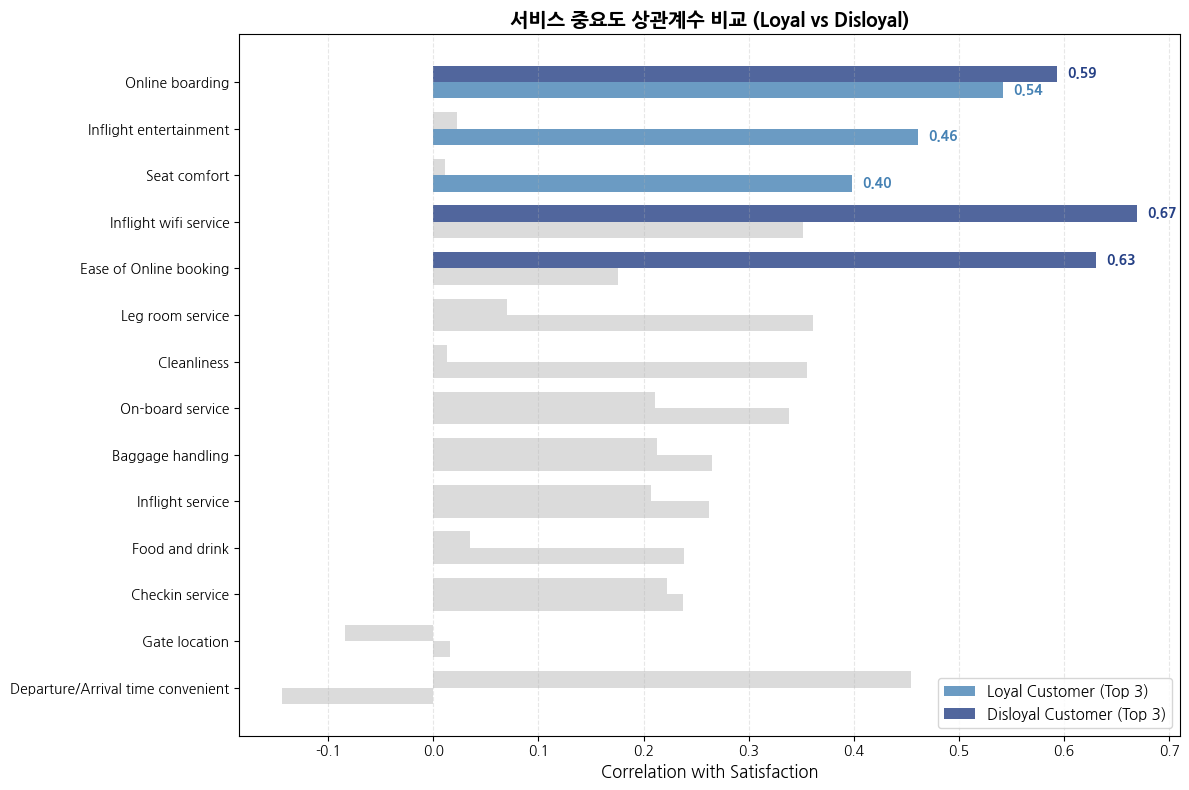

In [7]:
# 충성 고객 서비스 상관계수
loyal_corr = (
    loyal[service_cols + ['label']]
    .corr()['label']
    .drop('label')
    .sort_values(ascending=False)
)

# 비충성 고객 서비스 상관계수
disloyal_corr = (
    disloyal[service_cols + ['label']]
    .corr()['label']
    .drop('label')
    .sort_values(ascending=False)
)

# top3 출력
print("[Loyal Customer 상관계수]")
print(loyal_corr.head(3))

print("\n[Disloyal Customer 상관계수]")
print(disloyal_corr.head(3))

# Top 3 서비스 추출
loyal_top3 = set(loyal_corr.head(3).index)
disloyal_top3 = set(disloyal_corr.head(3).index)

# 모든 서비스 목록 (합집합)
all_services = list(set(loyal_corr.index) | set(disloyal_corr.index))

# 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Service': all_services,
    'Loyal': [loyal_corr.get(s, 0) for s in all_services],
    'Disloyal': [disloyal_corr.get(s, 0) for s in all_services]
})

# Top 3 합집합 (표시 우선순위가 높은 서비스)
all_top3 = loyal_top3 | disloyal_top3

# 정렬: Top 3 서비스들을 위로, 나머지는 아래
comparison_df['is_top3'] = comparison_df['Service'].isin(all_top3)
comparison_df = comparison_df.sort_values(['is_top3', 'Loyal'], ascending=[True, True])

# 색상 리스트 생성
colors_loyal = ['steelblue' if s in loyal_top3 else 'lightgray' 
                for s in comparison_df['Service']]
colors_disloyal = ['#254085' if s in disloyal_top3 else 'lightgray' 
                   for s in comparison_df['Service']]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(comparison_df))
bar_height = 0.35

# 막대 그래프 (각 막대마다 색상 지정)
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    # Loyal 막대
    bar1 = ax.barh(y_pos[i] - bar_height/2, row['Loyal'], 
                   bar_height, color=colors_loyal[i], alpha=0.8)
    
    # Disloyal 막대
    bar2 = ax.barh(y_pos[i] + bar_height/2, row['Disloyal'], 
                   bar_height, color=colors_disloyal[i], alpha=0.8)
    
    # Top 3이면 숫자 표시
    if row['Service'] in loyal_top3:
        ax.text(row['Loyal'] + 0.01, y_pos[i] - bar_height/2, 
                f"{row['Loyal']:.2f}", 
                va='center', ha='left', fontweight='bold', 
                color='steelblue', fontsize=10)
    
    if row['Service'] in disloyal_top3:
        ax.text(row['Disloyal'] + 0.01, y_pos[i] + bar_height/2, 
                f"{row['Disloyal']:.2f}", 
                va='center', ha='left', fontweight='bold', 
                color='#254085', fontsize=10)

# 축 설정
ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_df['Service'])
ax.set_xlabel('Correlation with Satisfaction', fontsize=12)
ax.set_title('서비스 중요도 상관계수 비교 (Loyal vs Disloyal)', fontsize=14, fontweight='bold')

# 범례 (Top 3만 표시)
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.8, label='Loyal Customer (Top 3)'),
    Patch(facecolor='#254085', alpha=0.8, label='Disloyal Customer (Top 3)'),
]
ax.legend(handles=legend_elements, fontsize=11)

# 그리드
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

**발견 1:** 충성 고객은 모든 서비스에 더 높은 점수를 주지만, 만족도 상관계수는 오히려 더 낮음 (기대치 역설)

**발견 2:** 충성/비충성 고객이 중요하게 생각하는 서비스가 완전히 다름
- 충성: 좌석·청결·기내서비스 (기본 경험)
- 비충성: 온라인·탑승·Wi-Fi (편의성)

**의문 발생:** 그런데 이 차이가 정말 "충성도" 때문일까?

In [8]:
# 충성 고객중 Business 비율
loyal_business_rate = loyal[loyal['Class'] == 'Business'].shape[0] / loyal.shape[0]

# 비충성 고객중 Business 비율
disloyal_business_rate = disloyal[disloyal['Class'] == 'Business'].shape[0] / disloyal.shape[0]

print(f"\nLoyal 고객 중 Business 비율 : {loyal_business_rate:.4f}")
print(f"Disloyal 고객 중 Business 비율 : {disloyal_business_rate:.4f}")


Loyal 고객 중 Business 비율 : 0.4982
Disloyal 고객 중 Business 비율 : 0.3875


데이터를 확인해보니:
- 충성 고객 중 Business 비율: 49.82%
- 비충성 고객 중 Business 비율: 38.75%
- **차이: 11%p**

**문제 인식: Confounding (혼재 효과)**

충성 고객에 Business가 11%p 더 많습니다.

그렇다면:
- "충성 고객이 좌석·청결·기내서비스 중시" = 충성도 때문?
- 아니면 "Business가 원래 이런 서비스 중시"하는데, 충성 고객에 Business가 많아서 그런 것?

→ **충성도 효과와 클래스 효과를 분리할 수 없음**

**방향 전환: 충성도 → 클래스**

**이유: 클래스는 차별 대우가 가능하기 때문**

충성 고객과 비충성 고객은 같은 좌석에 앉아 같은 서비스를 받습니다.
하지만 Business와 Economy는 지불한 비용이 다르므로 차별화된 서비스 제공이 정당합니다.

따라서:
- 충성도 기준: 같은 서비스를 받는데 다르게 대우하기 어려움
- 클래스 기준: 비용 차이로 차별 대우 가능 → **실행 가능한 전략 수립 가능**

**추가 고려: 거리별 분류**

같은 클래스라도 비행 거리에 따라 니즈가 다를 수 있습니다:
- Short (<1000mi): 단거리 통근
- Medium (1000-3000mi): 중거리 출장
- Long (3000mi+): 장거리 여행

실제로 항공사는 거리별로 다른 기체를 운영하므로, 거리별 차별화 전략도 실행 가능합니다.

→ 클래스 × 거리로 더 정밀한 분석 시도

**분석 대상:** 
Business와 Economy 중심 (전체의 92.8%)
- Eco Plus는 7.2% (7,494명)로 데이터는 충분하지만, 발표 시간 관계상 핵심인 Business vs Economy 대조에 집중

**가설 2: 클래스별·거리별로 어떤 서비스가 만족도에 영향을 미칠까?**

특히, 충성 고객 분석에서 3위였던 **좌석**이 정말 중요할까?

In [9]:
# 클래스와 이동 거리 컬럼 추출
class_cols = ['Class']
distance_col = ['Flight Distance']

# 서비스 변수와 클래스, 거리 그리고 satisfaction_binary만 존재하는 데이터프레임 생성
service_df = df[service_cols + class_cols + distance_col + ['label']]
service_df

# 0은 결측치 처리
service_df[service_cols] = service_df[service_cols].replace(0, np.nan)

# 기준: Short(<1000), Medium(1000~3000), Long(3000+)
# 데이터의 단위가 Mile이라고 가정했을 때의 통상적 기준입니다.
bins = [0, 1000, 3000, float('inf')]
labels = ['Short', 'Medium', 'Long']
service_df['Distance_Category'] = pd.cut(service_df['Flight Distance'], bins=bins, labels=labels)


# 그룹 정의
# Long에서 Eco, Eco plus의 수는 매우 적으므로 제외
groups = {
    'Biz_Long': service_df[(service_df['Class'] == 'Business') & (service_df['Distance_Category'] == 'Long')],
    'Biz_Medium': service_df[(service_df['Class'] == 'Business') & (service_df['Distance_Category'] == 'Medium')],
    'Biz_Short': service_df[(service_df['Class'] == 'Business') & (service_df['Distance_Category'] == 'Short')],
    'Eco_Long': service_df[(service_df['Class'] == 'Eco') & (service_df['Distance_Category'] == 'Long')],
    'Eco_Medium': service_df[(service_df['Class'] == 'Eco') & (service_df['Distance_Category'] == 'Medium')],
    'Eco_Short': service_df[(service_df['Class'] == 'Eco') & (service_df['Distance_Category'] == 'Short')]
}

# 각 그룹별로 데이터 수 확인
for group_name, group_df in groups.items():
    print(f"{group_name}: {group_df.shape[0]} samples")

Biz_Long: 8204 samples
Biz_Medium: 22737 samples
Biz_Short: 18724 samples
Eco_Long: 49 samples
Eco_Medium: 11090 samples
Eco_Short: 35606 samples


In [10]:
# 그룹별 label 비율 계산
group_label_rates = {}
for group_name, group_df in groups.items():
    label_rate = group_df['label'].mean()
    group_label_rates[group_name] = label_rate
    print(f"{group_name} - 만족도 비율: {label_rate:.4f}")

Biz_Long - 만족도 비율: 0.7788
Biz_Medium - 만족도 비율: 0.7324
Biz_Short - 만족도 비율: 0.6109
Eco_Long - 만족도 비율: 0.1224
Eco_Medium - 만족도 비율: 0.1654
Eco_Short - 만족도 비율: 0.1927



[Biz_Long 상관계수]
Inflight entertainment               0.610438
On-board service                     0.536601
Inflight service                     0.517538
Baggage handling                     0.509969
Leg room service                     0.505811
Online boarding                      0.478560
Seat comfort                         0.477509
Cleanliness                          0.475393
Checkin service                      0.430852
Food and drink                       0.258470
Inflight wifi service                0.193692
Departure/Arrival time convenient    0.018495
Ease of Online booking               0.008726
Gate location                        0.005853
Name: label, dtype: float64

[Biz_Medium 상관계수]
Inflight entertainment               0.545437
Online boarding                      0.543978
Seat comfort                         0.473792
On-board service                     0.472769
Cleanliness                          0.456914
Leg room service                     0.441870
Baggage handling

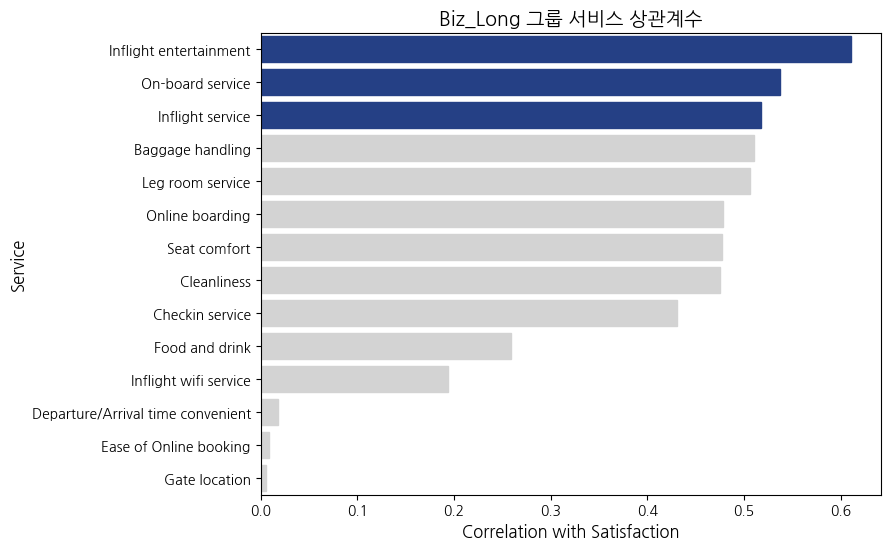

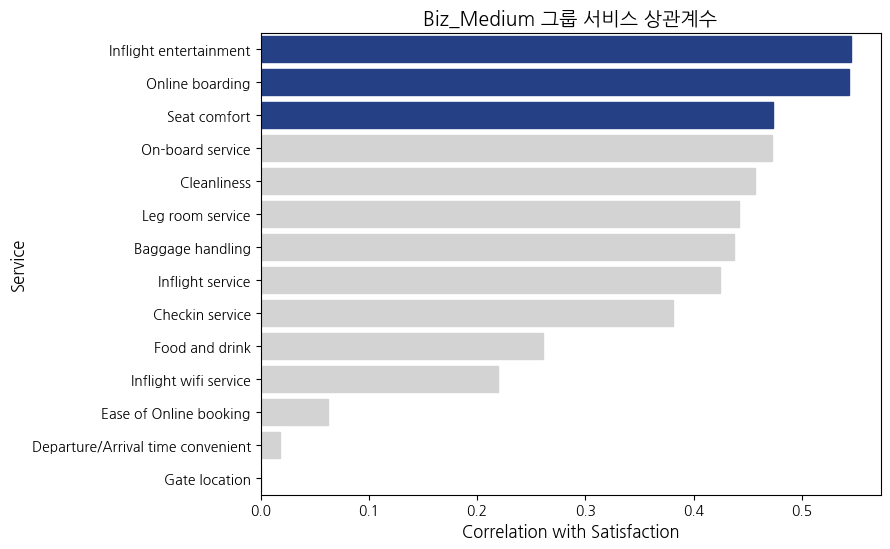

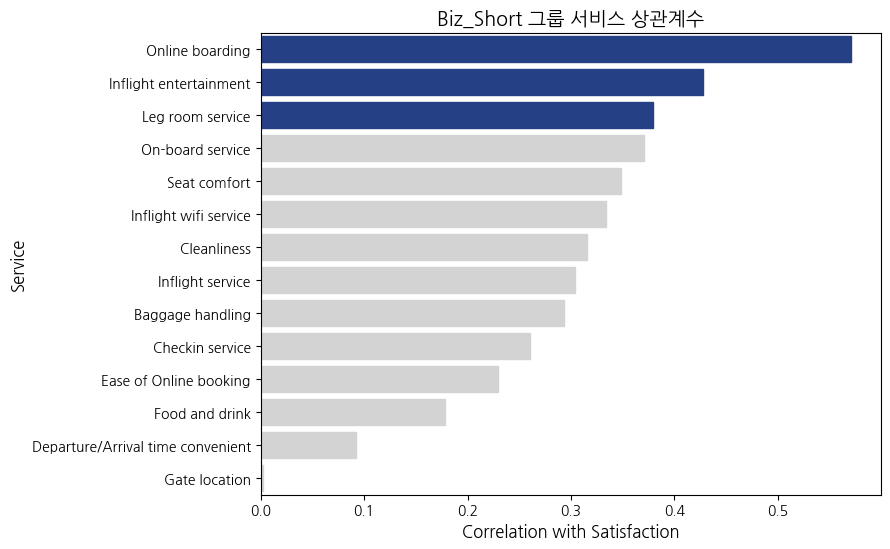

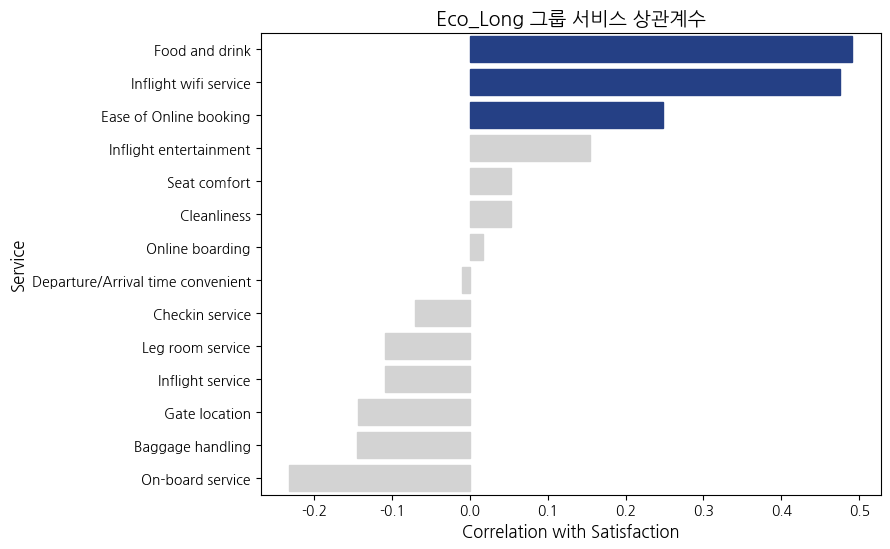

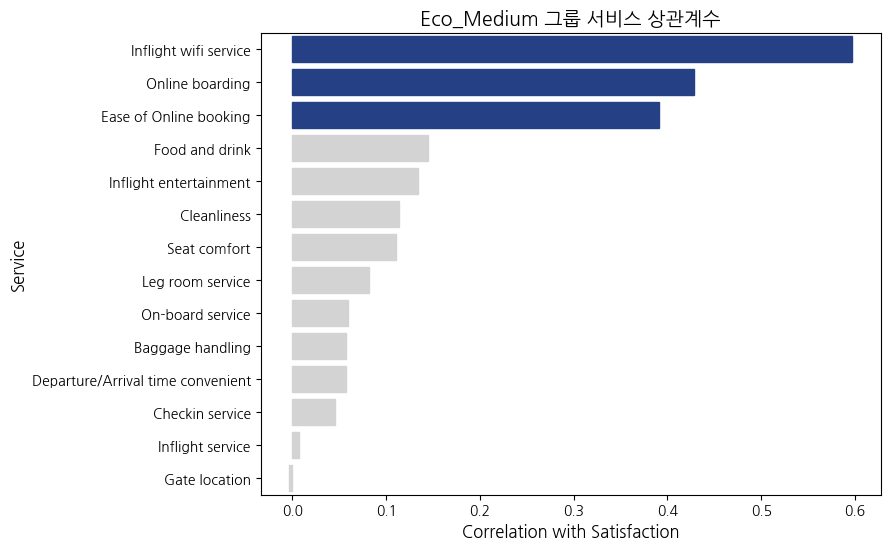

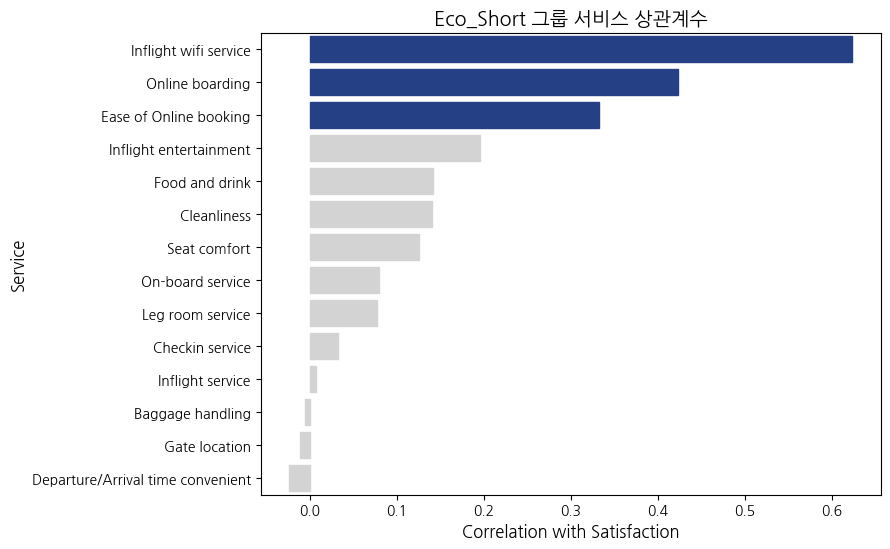

In [11]:
# 그룹별 상관계수 계산
group_correlations = {}
for group_name, group_df in groups.items():
    corr = group_df[service_cols + ['label']].corr()['label'].drop('label').sort_values(ascending=False)
    group_correlations[group_name] = corr
    print(f"\n[{group_name} 상관계수]")
    print(corr)

# 시각화
# 그룹별 상관계수 시각화 (subplot 없이 하나씩 전부 그리기)
for group_name, corr in group_correlations.items():
    plt.figure(figsize=(8, 6))
    sns.barplot(x=corr.values, y=corr.index, palette='viridis')
    plt.title(f'{group_name} 그룹 서비스 상관계수', fontsize=14)
    plt.xlabel('Correlation with Satisfaction', fontsize=12)
    plt.ylabel('Service', fontsize=12)

    # top3만 색상 강조, 나머지는 회색
    top3_services = corr.head(3).index
    for i, service in enumerate(corr.index):
        if service in top3_services:
            plt.gca().patches[i].set_color('#254085')
        else:
            plt.gca().patches[i].set_color('lightgray')

    plt.show()

### 1. 상관분석 시각화 결과: "우리의 상식은 틀렸다"

우리는 가설 검증을 위해 데이터를 6개 그룹(클래스×거리)으로 나누어 서비스 항목과 만족도 간의 상관계수(Correlation)를 확인했습니다.

결과는 예상과 달랐습니다.

**발견 1: Economy는 '안락함'보다 '연결(Connectivity)'이 생명이다**
- **Eco_Short / Eco_Medium:** 압도적인 1위는 **Inflight wifi service**입니다.
- **Eco_Long:** `Food and drink`가 1위지만, 데이터 노이즈(On-board service가 음수)가 있어 신뢰하기 어렵습니다.
- **충격적인 사실:** 좁은 좌석 때문에 가장 중요할 것 같았던 `Seat comfort`, `Leg room service`는 하위권에 머물렀습니다.
- **해석:** 승객들은 좁은 자리는 참아도, 인터넷이 끊기는 건 참지 못합니다.

**발견 2: Business는 거리에 따라 니즈가 완전히 바뀐다**
- **Biz_Short (단거리):** **Online boarding**이 1위입니다. 빠르게 수속 과정을 거쳐 라운지 이용과 휴식을 선호한다고 판단할 수도 있습니다.
- **Biz_Long (장거리):** **Inflight entertainment**가 1위로 급부상합니다. 긴 비행시간 동안 지루함을 달래주는 것이 가장 중요합니다.
- **공통점:** 여기서도 `Seat comfort`는 3~4위권입니다. 중요하긴 하지만, 만족도를 결정짓는 **'단 하나의 요소(Game Changer)'는 아닙니다.**


### 2. 상관분석의 한계: 이대로 결론 내릴 수 있을까?

상관분석 결과는 흥미롭지만, 이를 근거로 수십억 원의 투자를 결정하기엔 위험한 맹점이 있습니다.

**문제 1: 변수 간의 간섭 (Multicollinearity)**
- 서비스 항목들은 서로 독립적이지 않습니다.
- 예: 최신 기종 비행기는 `Wi-Fi`도 빠르고 `Cleanliness`도 깨끗합니다. 승객이 Wi-Fi 때문에 만족했는지, 청결 때문에 만족했는지 상관계수만으로는 발라낼 수 없습니다.

**문제 2: 상대적 중요도(Weight) 측정 불가**
- 상관계수가 높다는 건 관계가 있다는 뜻이지, 투자의 효율성을 말해주지 않습니다.
- 경영진 설득을 위해서는 "Wi-Fi에 1을 투자하면 만족 확률이 몇 배 오르는가?"에 대한 정량적 수치가 필요합니다.

**문제 3: 데이터 노이즈**
- `Eco_Long` 그래프에서 `On-board service`가 음의 상관관계(-0.2)를 보이는 것처럼, 단순 상관분석은 데이터의 노이즈에 취약해 잘못된 해석을 유도할 수 있습니다. 실제로 `Eco_Long`의 경우는 데이터 수가 매우 적어 정확한 판단을 내리기 어렵고 참고용으로만 사용 가능합니다.


### 3. 해결 방안: Logistic Regression (로지스틱 회귀분석)

위 문제를 해결하고 "진짜 핵심 변수"를 찾기 위해 **로지스틱 회귀분석**을 도입합니다.

**목적:**
다른 변수들을 통제한 상태에서, 특정 서비스 점수가 1점 오를 때 **만족할 확률(Odds)이 어떻게 변하는지** 계수(Coefficient)를 통해 산출합니다.

**분석 절차:**
1. **표준화 (StandardScaler):** 변수 간 단위 차이를 없애 공정한 비교를 가능하게 함
2. **모델링:** 6개 그룹별로 별도의 회귀 모델 생성
3. **결과 도출:** 각 서비스 항목의 **회귀계수(Coefficient)** 크기를 비교하여 투자 우선순위 선정

**검증 계획:**
회귀분석으로 도출된 핵심 서비스가 정말 유의미한지 확인하기 위해, 분석 후 **T-test(평균 검정)** 를 통해 만족/불만족 그룹 간의 실제 점수 차이를 교차 검증할 것입니다.


==================== Economy Groups 분석 결과 ====================

[Eco_Long 중요도(Coefficient) Top 5]
                  Service  Coefficient
4          Food and drink     1.068622
0   Inflight wifi service     0.677405
7  Inflight entertainment     0.392398
5         Online boarding     0.251662
6            Seat comfort     0.110071

[Eco_Medium 중요도(Coefficient) Top 5]
                  Service  Coefficient
0   Inflight wifi service     2.468868
5         Online boarding     0.237029
11        Checkin service     0.106788
10       Baggage handling     0.104977
8        On-board service     0.095951

[Eco_Short 중요도(Coefficient) Top 5]
                   Service  Coefficient
0    Inflight wifi service     2.589711
7   Inflight entertainment     0.324137
11         Checkin service     0.158072
8         On-board service     0.121000
3            Gate location     0.093019


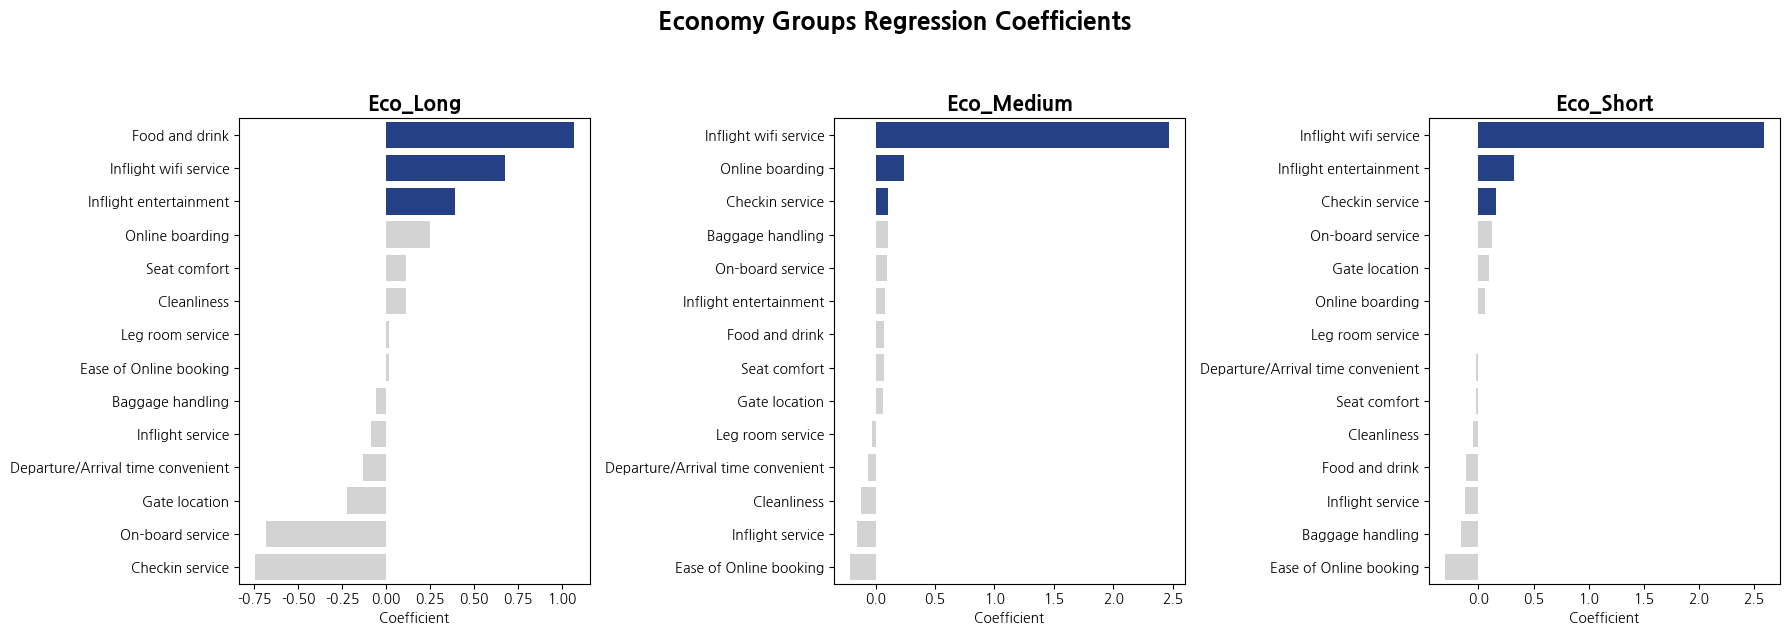


==================== Business Groups 분석 결과 ====================

[Biz_Long 중요도(Coefficient) Top 5]
             Service  Coefficient
11   Checkin service     0.785597
13       Cleanliness     0.673944
8   On-board service     0.656114
9   Leg room service     0.526753
5    Online boarding     0.480848

[Biz_Medium 중요도(Coefficient) Top 5]
             Service  Coefficient
5    Online boarding     0.942035
9   Leg room service     0.532138
8   On-board service     0.511019
11   Checkin service     0.459652
13       Cleanliness     0.430201

[Biz_Short 중요도(Coefficient) Top 5]
                  Service  Coefficient
5         Online boarding     1.218710
0   Inflight wifi service     0.639258
7  Inflight entertainment     0.531278
9        Leg room service     0.515423
8        On-board service     0.368405


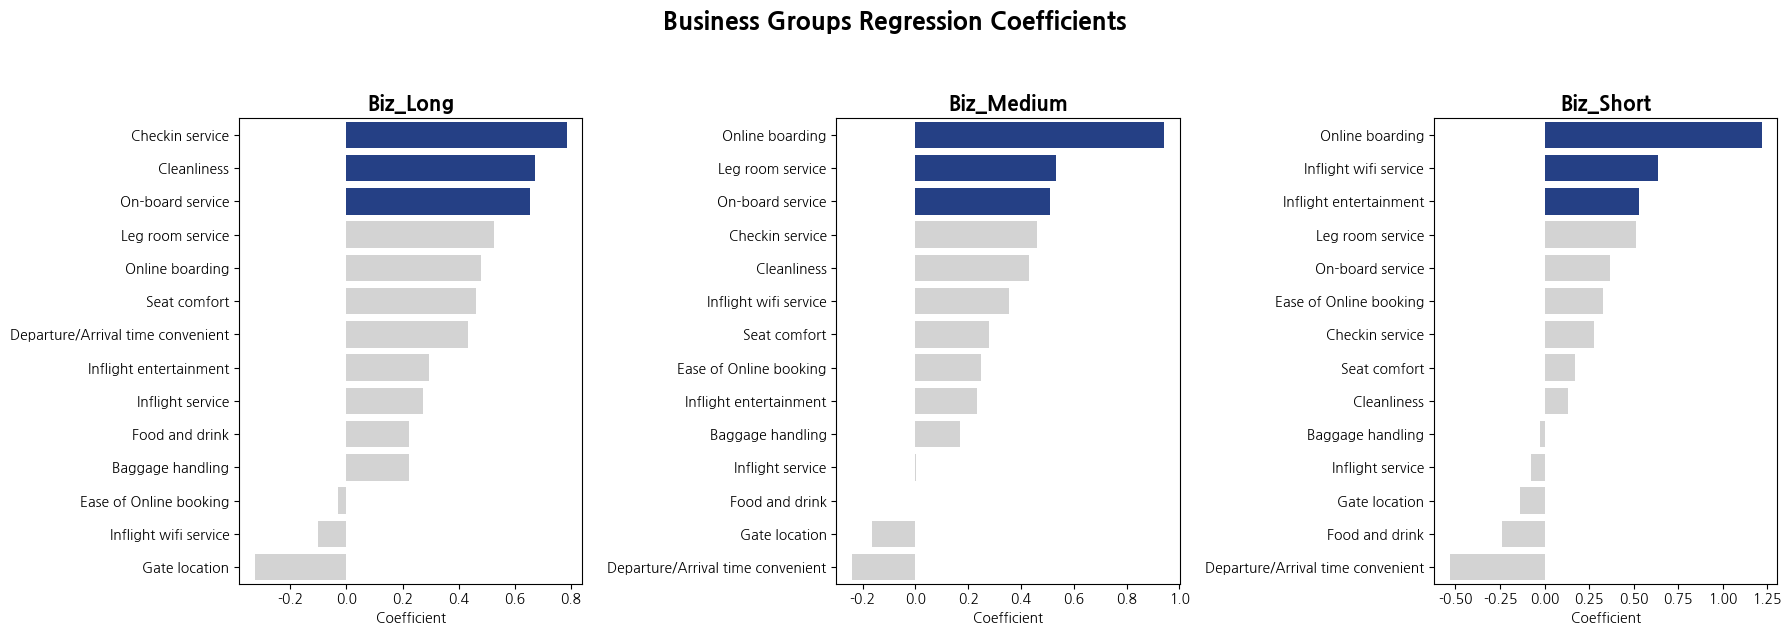

In [15]:


# ---------------------------------------------------------
# 함수 정의: 로지스틱 회귀분석 수행 및 결과 반환
# ---------------------------------------------------------
def logistic_regression_analysis(df, service_cols):
    # 독립변수와 종속변수 설정
    X = df[service_cols]
    y = df['label']
    
    # 결측치 처리: 평균으로 대체
    X = X.fillna(X.mean())
    
    # 표준화 (StandardScaler)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 로지스틱 회귀 모델 적합
    model = LogisticRegression(random_state=42, max_iter=1000) 
    model.fit(X_scaled, y)
    
    # 회귀계수 추출
    coefficients = model.coef_[0]
    
    # 결과 데이터프레임 생성
    results_df = pd.DataFrame({
        'Service': service_cols,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)
    
    return results_df

# ---------------------------------------------------------
# 시각화 함수 정의 (코드 중복 방지)
# ---------------------------------------------------------
def plot_group_coefficients(group_list, title_main):
    """
    특정 그룹 리스트(예: 이코노미 그룹들)를 받아 1행 n열의 서브플롯을 그리는 함수
    """
    n_cols = len(group_list)
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6)) # 가로로 길게 배치
    
    # 그룹이 1개일 경우 axes가 배열이 아니므로 리스트로 변환
    if n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    print(f"\n{'='*20} {title_main} 분석 결과 {'='*20}")

    for i, group_name in enumerate(group_list):
        group_df = groups[group_name]
        
        # 1. 회귀분석 수행
        results_df = logistic_regression_analysis(group_df, service_cols)
        
        # 2. 콘솔 출력
        print(f"\n[{group_name} 중요도(Coefficient) Top 5]")
        print(results_df.head(5))
        
        # 3. 시각화 (Barplot)
        sns.barplot(
            x='Coefficient', 
            y='Service', 
            data=results_df, 
            ax=axes[i], 
            palette='viridis'
        )
        
        # 그래프 꾸미기
        axes[i].set_title(f'{group_name}', fontsize=15, fontweight='bold')
        axes[i].set_xlabel('Coefficient')
        axes[i].set_ylabel('')
        
        # Top 3 강조 (색상 변경)
        # seaborn barplot은 데이터 정렬 순서대로 patches가 생성됨
        for j, patch in enumerate(axes[i].patches):
            if j < 3: # 상위 3개
                patch.set_facecolor('#254085') # 진한 남색 (강조)
            else:
                patch.set_facecolor('lightgray') # 회색 (비강조)

    plt.suptitle(f'{title_main} Regression Coefficients', fontsize=18, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 실행: 그룹 분리 및 시각화
# ---------------------------------------------------------

# 그룹 키 분리 (이코노미 / 비즈니스)
# groups 딕셔너리의 키 이름에 'Eco' 또는 'Biz'가 포함되어 있다고 가정합니다.
eco_keys = sorted([k for k in groups.keys() if 'Eco' in k])
biz_keys = sorted([k for k in groups.keys() if 'Biz' in k])

# 1. 이코노미 그룹 시각화 (1행 3열)
if eco_keys:
    plot_group_coefficients(eco_keys, "Economy Groups")

# 2. 비즈니스 그룹 시각화 (1행 3열)
if biz_keys:
    plot_group_coefficients(biz_keys, "Business Groups")

### 분석 결과: "우리는 그동안 돈을 엉뚱한 곳에 쓰고 있었습니다."

우리는 다른 변수들을 통제한 상태에서, 각 서비스가 만족도에 미치는 순수한 영향력(Coefficient)을 측정했습니다.
결과는 경영진의 직관(좌석이 최고다)을 완전히 뒤집습니다.

#### 1. 핵심 발견: '좌석(Seat comfort)'의 배신
* **Fact:** 6개 그룹 모두에서 `Seat comfort`는 단 한 번도 **Top 3(진한 파란색)**에 들지 못했습니다.
* **해석:** 좌석은 만족을 위한 '플러스 요인(Satisfier)'이 아니라, 갖춰져야 본전인 '위생 요인(Hygiene Factor)'에 가깝습니다. 승객들은 좌석이 조금 더 편하다고 해서 "매우 만족"을 누르지 않지만, 다른 결정적인 요소(Wi-Fi, 신속한 탑승 등)에는 즉각 반응합니다.


#### 2. Economy 그룹 분석: "디지털 마취제와 생존 본능"

* **Eco_Short / Eco_Medium (단·중거리): "인터넷만 되면 좁은 건 참는다"**
    * **인사이트:** `Inflight wifi service`의 막대 길이를 보십시오. 계수가 **2.5**를 넘나듭니다. 다른 항목들과 비교가 안 될 정도로 **압도적인 영향력**입니다.
    * **해석:** 좁은 이코노미석에서 승객을 구원하는 건 넓은 자리가 아니라 **스마트폰**입니다. Wi-Fi가 빵빵 터지면 승객은 불편함을 잊고 만족합니다. 이것은 가장 가성비 높은 투자처입니다.
* **Eco_Long (장거리): "금강산도 식후경"**
    * **인사이트:** 장거리로 가자마자 1순위가 `Food and drink`로 바뀝니다.
    * **해석:** 10시간이 넘는 비행에서는 '배고픔'과 '지루함' 해결이 최우선입니다. 장거리 이코노미 승객에게는 비싼 좌석 개조보다 **맛있는 기내식 한 끼**가 만족도를 올리는 열쇠입니다.


#### 3. Business 그룹 분석: "효율성(Efficiency) vs 대우(Hospitality)"

* **Biz_Short / Biz_Medium (단·중거리): "나를 기다리게 하지 마라"**
    * **인사이트:** `Online boarding`이 부동의 1위입니다.
    * **해석:** 이들은 바쁜 비즈니스맨들입니다. 기내 서비스보다 중요한 건 **'공항에서의 시간 단축'**입니다. 스마트폰으로 빠르게 수속하고 바로 라운지 혹은 비행기에 타는 경험이 최고의 만족을 줍니다.
* **Biz_Long (장거리): "호텔급 서비스를 원한다"**
    * **인사이트:** 여기서는 `Online boarding`이 사라지고, `Checkin service`, `Cleanliness`, `On-board service`가 Top 3를 차지합니다.
    * **해석:** 장거리 비즈니스 승객은 비행기를 '호텔'로 인식합니다. 직원(지상직/승무원)이 나를 얼마나 정중하게 대하는지, 내 자리가 얼마나 깨끗한지가 만족도를 결정합니다. 즉, **Human Touch**가 핵심입니다.



### 4. 경영진을 위한 최종 제언 (투자 전략)

이 데이터를 바탕으로 가설 2의 결론을 내립니다.

> **"모든 승객에게 비싼 좌석을 제공하려는 시도는 예산 낭비입니다."**

**데이터 기반 투자 우선순위:**

1.  **Economy 전 노선:** 좌석 간격 1인치 늘리는 예산(수백억)을 전액 삭감하고, **고속 기내 Wi-Fi 설비**에 투자하십시오. (만족도 상승 효과 5배 이상 예상)
2.  **Business 단거리:** 인적 서비스 교육보다 **앱(App) UI/UX 개선과 하이패스 탑승 시스템** 구축에 집중하십시오.
3.  **Business 장거리:** 이곳이 바로 **'프리미엄 서비스'**가 필요한 유일한 곳입니다. 청결도 관리와 승무원 서비스 품질에 예산을 배정하십시오.


==================== Economy Groups T-test 결과 ====================

[Eco_Long 점수 차이(Diff) Top 5]
                  Service  Diff_Score       P-value
0   Inflight wifi service    1.604651  3.679040e-15
4          Food and drink    1.604651  4.095589e-03
2  Ease of Online booking    1.034884  2.412089e-02
7  Inflight entertainment    0.573643  1.715284e-01
6            Seat comfort    0.217054  7.920113e-01

[Eco_Medium 점수 차이(Diff) Top 5]
                  Service  Diff_Score        P-value
0   Inflight wifi service    1.918946   0.000000e+00
5         Online boarding    1.422745   0.000000e+00
2  Ease of Online booking    1.285833  4.884798e-259
4          Food and drink    0.526193   4.737847e-51
7  Inflight entertainment    0.494274   1.178648e-44

[Eco_Short 점수 차이(Diff) Top 5]
                  Service  Diff_Score        P-value
0   Inflight wifi service    1.926981   0.000000e+00
5         Online boarding    1.349585   0.000000e+00
2  Ease of Online booking    1.040744   0.000000e+

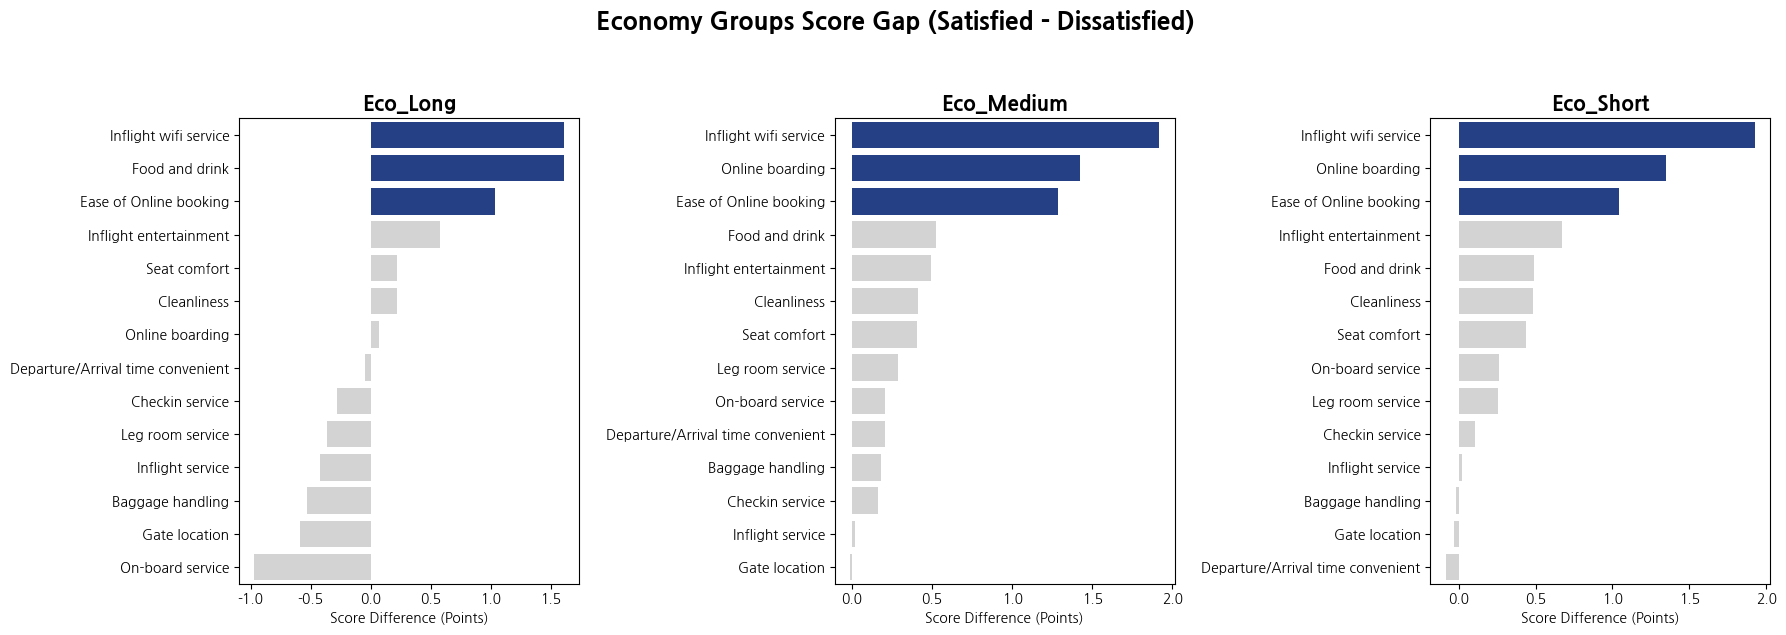


==================== Business Groups T-test 결과 ====================

[Biz_Long 점수 차이(Diff) Top 5]
                   Service  Diff_Score  P-value
7   Inflight entertainment    1.699295      0.0
8         On-board service    1.550270      0.0
9         Leg room service    1.462466      0.0
12        Inflight service    1.429448      0.0
10        Baggage handling    1.415249      0.0

[Biz_Medium 점수 차이(Diff) Top 5]
                   Service  Diff_Score  P-value
7   Inflight entertainment    1.487279      0.0
5          Online boarding    1.380075      0.0
8         On-board service    1.268745      0.0
13             Cleanliness    1.242932      0.0
6             Seat comfort    1.218506      0.0

[Biz_Short 점수 차이(Diff) Top 5]
                  Service  Diff_Score  P-value
5         Online boarding    1.430950      0.0
7  Inflight entertainment    1.141869      0.0
9        Leg room service    0.957928      0.0
6            Seat comfort    0.920468      0.0
8        On-board service  

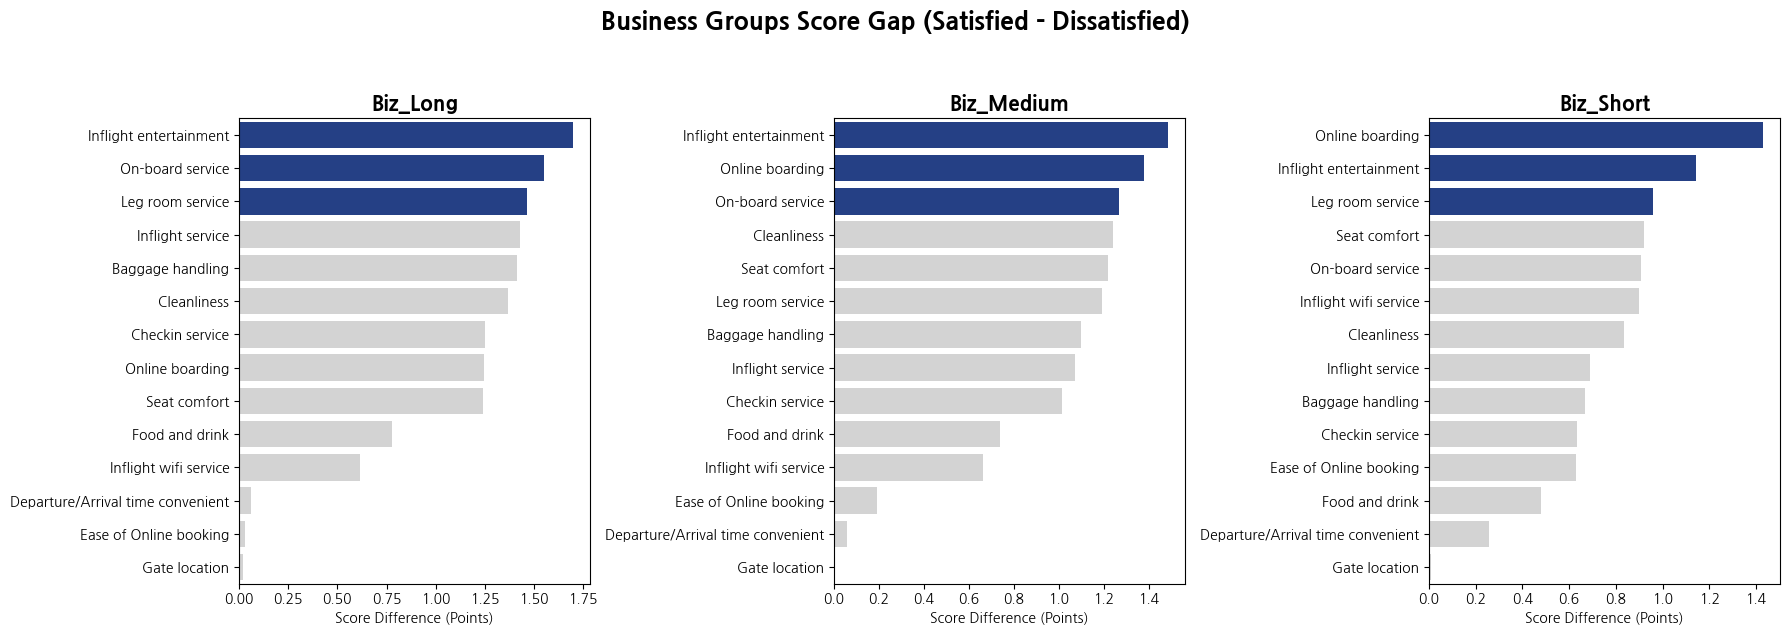

In [19]:


# ---------------------------------------------------------
# 1. T-test 계산 함수
# ---------------------------------------------------------
def calculate_ttest_group(df, service_cols):
    results = []
    satisfied = df[df['label'] == 1]
    dissatisfied = df[df['label'] == 0]
    
    for col in service_cols:
        score_sat = satisfied[col].dropna()
        score_dissat = dissatisfied[col].dropna()
        
        t_stat, p_val = stats.ttest_ind(score_sat, score_dissat, equal_var=False)
        
        mean_sat = score_sat.mean()
        mean_dissat = score_dissat.mean()
        diff = mean_sat - mean_dissat
        
        results.append({
            'Service': col,
            'T-statistic': t_stat,
            'P-value': p_val,
            'Mean_Satisfied': mean_sat,
            'Mean_Dissatisfied': mean_dissat,
            'Diff_Score': diff
        })
        
    return pd.DataFrame(results).sort_values(by='Diff_Score', ascending=False)

# ---------------------------------------------------------
# 2. 시각화 함수 (투명도 로직 제거!)
# ---------------------------------------------------------
def plot_ttest_results(group_list, title_main):
    n_cols = len(group_list)
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 6))
    
    if n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    print(f"\n{'='*20} {title_main} T-test 결과 {'='*20}")

    for i, group_name in enumerate(group_list):
        group_df = groups[group_name]
        res_df = calculate_ttest_group(group_df, service_cols)
        
        print(f"\n[{group_name} 점수 차이(Diff) Top 5]")
        print(res_df[['Service', 'Diff_Score', 'P-value']].head(5))
        
        # 기본 막대 생성
        sns.barplot(
            x='Diff_Score', 
            y='Service', 
            data=res_df, 
            ax=axes[i], 
            color='lightgray' # 기본 회색
        )
        
        axes[i].set_title(f'{group_name}', fontsize=15, fontweight='bold')
        axes[i].set_xlabel('Score Difference (Points)')
        axes[i].set_ylabel('')
        
        # [수정됨] P-value 상관없이 색상만 Top 3 강조
        for j, (idx, row) in enumerate(res_df.iterrows()):
            # 1) 색상 결정 (Top 3만 진한 남색)
            if j < 3:
                face_color = '#254085'
            else:
                face_color = 'lightgray'
            
            # 2) 적용 (Alpha는 무조건 1.0으로 고정하여 선명하게)
            axes[i].patches[j].set_facecolor(face_color)
            axes[i].patches[j].set_alpha(1.0) 

    plt.suptitle(f'{title_main} Score Gap (Satisfied - Dissatisfied)', fontsize=18, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------
# 3. 실행
# ---------------------------------------------------------

eco_keys = sorted([k for k in groups.keys() if 'Eco' in k])
biz_keys = sorted([k for k in groups.keys() if 'Biz' in k])

if eco_keys:
    plot_ttest_results(eco_keys, "Economy Groups")

if biz_keys:
    plot_ttest_results(biz_keys, "Business Groups")

**[다음 단계] 가설 3: "그런데, 비행기가 늦게 뜨면 어떡하죠?"**

이제 우리는 완벽한 서비스 전략을 짰습니다. 하지만 항공사에는 우리가 통제할 수 없는 치명적인 변수가 있습니다. 바로 **지연(Delay)**입니다.

- 문제 제기: "Wi-Fi가 빠르고 승무원이 친절해도, 비행기가 3시간 늦게 도착하면 고객이 만족할까요?"

- 가설 3: "출발 지연(Departure Delay)보다 도착 지연(Arrival Delay)이 고객 만족도에 더 치명적일 것이다."
    - 왜? 출발이 늦어도 도착만 제시간에 하면(회복 운항) 용서되지만, 약속 시간에 늦는(도착 지연) 건 용서가 안 되기 때문입니다.